# Causal Inference in Marketing

In [18]:
import os
import pandas as pd
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import col, mean
os.environ['JAVA_HOME'] = "/usr/lib/jvm/java-11-openjdk-amd64"

from causalml.inference.meta import BaseTClassifier
from causalml.metrics.visualize import plot, auuc_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

## Read in and Prep Data

In [15]:
# df = pd.read_csv("data/email_data.csv")
# df['treatment'] = df['segment'].map({'No E-Mail': 0, 'Womens E-Mail': 1, 'Mens E-Mail': 2})
# df = df.query('treatment in [0,1]')
# df = pd.read_csv("data/criteo-uplift-v2.1.csv")
spark = SparkSession.builder.appName("Load 3GB Causal Inference Data").getOrCreate()
df = spark.read.csv("data/criteo-uplift-v2.1.csv", header=True, inferSchema=True)
n = df.count()
df.show(3)

+------------------+------------------+-----------------+-----------------+------------------+-----------------+-------------------+-----------------+------------------+------------------+-----------------+--------------------+---------+----------+-----+--------+
|                f0|                f1|               f2|               f3|                f4|               f5|                 f6|               f7|                f8|                f9|              f10|                 f11|treatment|conversion|visit|exposure|
+------------------+------------------+-----------------+-----------------+------------------+-----------------+-------------------+-----------------+------------------+------------------+-----------------+--------------------+---------+----------+-----+--------+
|12.616364906986497|10.059654474774547|8.976428838331028|4.679881620097284|10.280525225748212|4.115453421277861|0.29444271125560606|4.833814577796811|3.9553959684262416|13.190055934673358|5.300374864042156|-0

In [21]:
# df2 = df.limit(10000)
df2.count()
df2.columns

['f0',
 'f1',
 'f2',
 'f3',
 'f4',
 'f5',
 'f6',
 'f7',
 'f8',
 'f9',
 'f10',
 'f11',
 'treatment',
 'conversion',
 'visit',
 'exposure']

In [100]:
# convert categorical columns to binaries
# zip_code_dummies = pd.get_dummies(df['zip_code'], prefix='zip_code')*1
# channel_dummies = pd.get_dummies(df['channel'], prefix='channel')*1
# df = pd.concat([df, zip_code_dummies, channel_dummies], axis=1)
# df.head(3)

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend,treatment,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0,0,0.0,1,0,1,0,0,1,0
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0,0,1,0,0,0,0,1
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0,0,0.0,1,0,1,0,0,0,1


In [17]:
df.select(
    F.mean("visit").alias("Percentage of users that visit"),
    F.mean("conversion").alias("Percentage of users that convert"),
    (F.sum("conversion") / F.sum("visit")).alias("Percentage of visitors that convert"),
).show()

+------------------------------+--------------------------------+-----------------------------------+
|Percentage of users that visit|Percentage of users that convert|Percentage of visitors that convert|
+------------------------------+--------------------------------+-----------------------------------+
|          0.046992000911042324|            0.002916680257907384|                0.06206759025709019|
+------------------------------+--------------------------------+-----------------------------------+



In [20]:
# Filter for control group and calculate visit and conversion rates
control_df = df.filter(col("treatment") == 0)
control_visit_rate = control_df.agg(mean("visit")).collect()[0][0]
control_conversion_rate = control_df.filter(col("visit") == 1).agg(mean("conversion")).collect()[0][0]

# Filter for treatment group and calculate visit and conversion rates
treatment_df = df.filter(col("treatment") == 1)
treatment_visit_rate = treatment_df.agg(mean("visit")).collect()[0][0]
treatment_conversion_rate = treatment_df.filter(col("visit") == 1).agg(mean("conversion")).collect()[0][0]

# Print the results
print(f"The control group had an {round(control_visit_rate, 4)*100}% visit rate, of these visits there was a {round(control_conversion_rate, 4)*100}% conversion rate")
print(f"The treatment group had a {round(treatment_visit_rate, 4)*100}% visit rate, of these visits there was a {round(treatment_conversion_rate, 4)*100}% conversion rate")

The control group had an 3.82% visit rate, of these visits there was a 5.07% conversion rate
The treatment group had a 4.8500000000000005% visit rate, of these visits there was a 6.36% conversion rate


In [101]:
#control_visit_rate = df.query("treatment == 0")['visit'].mean()
#control_conversion_rate = df.query("treatment == 0 and visit == 1")['conversion'].mean()
#print(f"The control group had an {round(control_visit_rate, 2)*100}% visit rate, of these visits there was a {round(control_conversion_rate, 2)*100}% conversion rate")

#treatment_visit_rate = df.query("treatment == 1")['visit'].mean()
#treatment_conversion_rate = df.query("treatment == 1 and visit == 1")['conversion'].mean()
#print(f"The treatment group had a {round(treatment_visit_rate, 2)*100}% visit rate, of these visits there was a {round(treatment_conversion_rate, 2)*100}% conversion rate")

The control group had an 11.0% visit rate, of these visits there was a 5.0% conversion rate
The treatment group had a 15.0% visit rate, of these visits there was a 6.0% conversion rate


In [217]:
# Features, treatment, and outcome
X = df[['recency', 'history', 'womens', 'zip_code_Rural', 'zip_code_Urban', 'channel_Web']]
T = df['treatment']
y = df['visit']

In [218]:
# Split the data into train and test
X_train, X_test, T_train, T_test, y_train, y_test = train_test_split(X, T, y, test_size=0.2, random_state=42)

In [219]:
# Let's use the t-learner as the causal inference model with XGBoost as the underlying estimator
t_learner = BaseTClassifier(learner=XGBClassifier(max_depth=3, learning_rate = 0.2, reg_lambda = 0.2, random_state=42))

In [220]:
# Fit the model
t_learner.fit(X_train, T_train, y_train)

In [221]:
ite_test = t_learner.predict(X_test)
ite_test = [value[0] for value in ite_test]

In [284]:
df_test = pd.DataFrame({"treatment": T_test, "ite": ite_test, "outcome": y_test})
df_test.head()

,treatment,ite,outcome
7730,0,-0.002084,0
17594,1,0.030584,0
14481,1,0.091401,0
20003,1,0.074211,0
19981,0,0.065424,0


## Uplift curve
Let's make the uplift curve, note while this looks similar to the AUC curve, it is different. The x-axis in this case represents the population selected for treatment. So at the origin when x = 0, this is when we do not give treatment to anybody; in contrast when x = 1, this is when we give treatment to everybody. The y-axis measures the uplift between the difference of predicted treatment and control outcomes. A standard thing to do, is to also sort the individuals so that the highest uplift individuals have their uplift recorded first (by sorting them from highest uplift to lowest) which will give the curve the concave shape when it out performs the baseline random treatment assignment model

In [286]:
# Sort the test data by uplift score in descending order
df_test_sorted = df_test.sort_values(by='ite', ascending=False)
df_test_sorted.head(6)

,treatment,ite,outcome
24504,1,0.386675,0
26971,0,0.380419,0
40129,1,0.371092,0
30400,1,0.369487,0
46913,0,0.343383,0
14957,0,0.339190,1


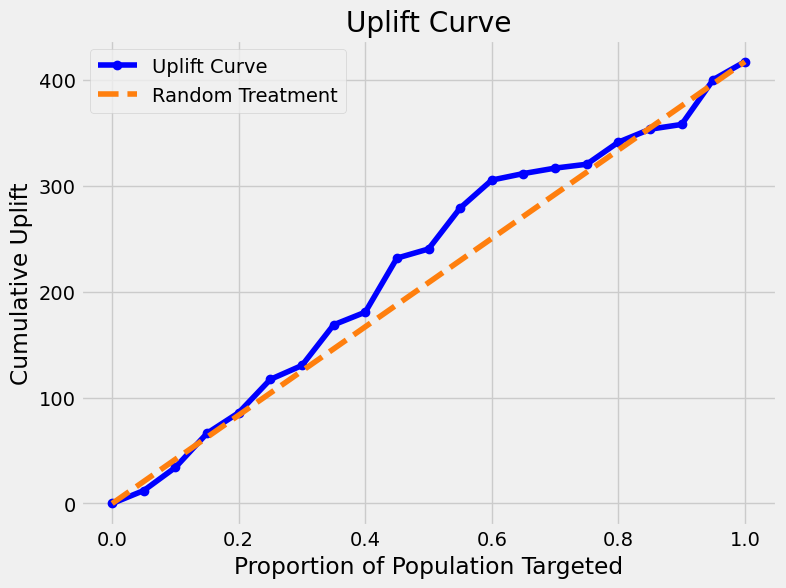

In [224]:
# Calculate the cumulative uplift curve
num_bins = 20  # Number of quantiles to divide the data into
df_test_sorted['bin'] = pd.qcut(df_test_sorted.index, q=num_bins, labels=False)

# Initialize cumulative metrics for uplift curve calculation
cumulative_treatment_effect = [0]
cumulative_population = [0]
cumulative_uplift = 0

for bin_num in range(num_bins):
    # Subset data for the current bin
    bin_data = df_test_sorted[df_test_sorted['bin'] == bin_num]
    
    treatment_outcome = bin_data.query('treatment == 1')['outcome'].mean()
    control_outcome = bin_data.query('treatment == 0')['outcome'].mean()
    
    # Calculate bin uplift and cumulative uplift
    bin_uplift = (treatment_outcome - control_outcome) * len(bin_data)
    cumulative_uplift += bin_uplift
    
    # Store cumulative values for plotting
    cumulative_treatment_effect.append(cumulative_uplift)
    cumulative_population.append((bin_num + 1) / num_bins)

# Plot the uplift curve
plt.figure(figsize=(8, 6))
plt.plot(
    cumulative_population, 
    cumulative_treatment_effect, 
    marker='o', 
    color='b', 
    label='Uplift Curve'
)
plt.plot(
    [0, max(cumulative_population)],
    [0, max(cumulative_treatment_effect)],
    "--",
    color="tab:orange",
    label="Random Treatment",
)
plt.xlabel('Proportion of Population Targeted')
plt.ylabel('Cumulative Uplift')
plt.title('Uplift Curve')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [225]:

auuc_score(df_test_sorted, outcome_col='outcome', treatment_col='treatment')
# auuc_score(df, tmle=True, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
#            n_segment=5, cv=kf, calibrate_propensity=True, ci=False)

ite       0.623534
bin       0.465670
Random    0.490255
dtype: float64

In [226]:
# run for loop to find hyperparameters
max_depth_values = [3, 4, 5, 6, 10]
learning_rate_values = [0.1, 0.5, 1]
reg_lambda_values = [0, 1, 2]

In [229]:
results = pd.DataFrame({'max_depth': [], 'learning_rate': [], 'reg_lambda': [], 'auuc': []})
for max_depth in max_depth_values:
    for learning_rate in learning_rate_values:
        for reg_lambda in reg_lambda_values:
            t_learner = BaseTClassifier(learner=XGBClassifier(max_depth=max_depth, learning_rate = learning_rate, reg_lambda = reg_lambda, random_state=42))
            t_learner.fit(X_train, T_train, y_train)
            ite_test = t_learner.predict(X_test)
            ite_test = [value[0] for value in ite_test]
            df_test = pd.DataFrame({"treatment": T_test, "ite": ite_test, "outcome": y_test})
            df_test_sorted = df_test.sort_values(by='ite', ascending=False)
            this_score = auuc_score(df_test_sorted, outcome_col='outcome', treatment_col='treatment')
            this_result = pd.DataFrame({
                'max_depth': [max_depth], 
                'learning_rate': [learning_rate], 
                'reg_lambda': [reg_lambda],
                'auuc': [this_score['ite']]
            })
            results = pd.concat([results, this_result], axis=0)

results.sort_values(by='auuc', ascending=False)
display(results.head(3))

,max_depth,learning_rate,reg_lambda,auuc
0,3.0,0.1,0.0,0.636175
0,3.0,0.1,1.0,0.634141
0,3.0,0.1,2.0,0.638739


## Run again with best parameter setting

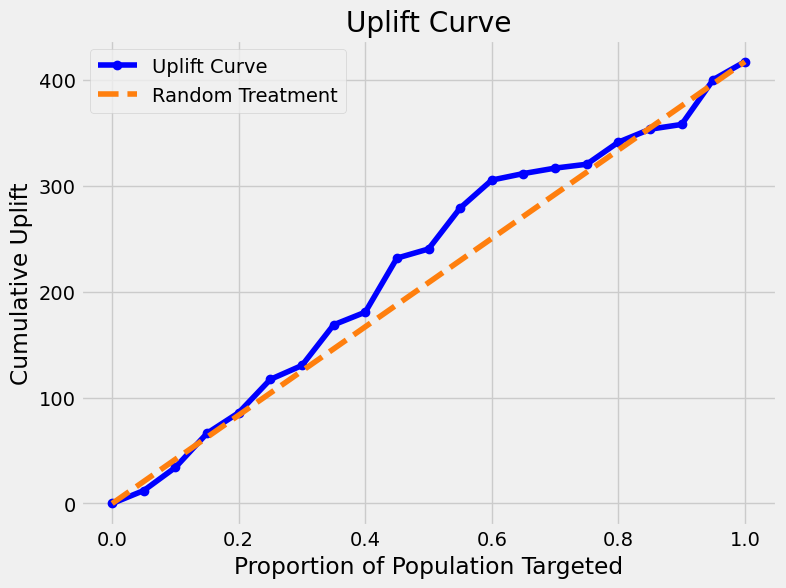

In [230]:
max_depth = 3
learning_rate = 0.1
reg_lambda = 0

t_learner = BaseTClassifier(learner=XGBClassifier(max_depth=max_depth, learning_rate = learning_rate, reg_lambda = reg_lambda, random_state=42))
t_learner.fit(X_train, T_train, y_train)
ite_test = t_learner.predict(X_test)
ite_test = [value[0] for value in ite_test]
df_test = pd.DataFrame({"treatment": T_test, "ite": ite_test, "outcome": y_test})
df_test_sorted = df_test.sort_values(by='ite', ascending=False)

# Calculate the cumulative uplift curve
num_bins = 20  # Number of quantiles to divide the data into
df_test_sorted['bin'] = pd.qcut(df_test_sorted.index, q=num_bins, labels=False)

# Initialize cumulative metrics for uplift curve calculation
cumulative_treatment_effect = [0]
cumulative_population = [0]
cumulative_uplift = 0

for bin_num in range(num_bins):
    # Subset data for the current bin
    bin_data = df_test_sorted[df_test_sorted['bin'] == bin_num]
    
    treatment_outcome = bin_data.query('treatment == 1')['outcome'].mean()
    control_outcome = bin_data.query('treatment == 0')['outcome'].mean()
    
    # Calculate bin uplift and cumulative uplift
    bin_uplift = (treatment_outcome - control_outcome) * len(bin_data)
    cumulative_uplift += bin_uplift
    
    # Store cumulative values for plotting
    cumulative_treatment_effect.append(cumulative_uplift)
    cumulative_population.append((bin_num + 1) / num_bins)

# Plot the uplift curve
plt.figure(figsize=(8, 6))
plt.plot(
    cumulative_population, 
    cumulative_treatment_effect, 
    marker='o', 
    color='b', 
    label='Uplift Curve'
)
plt.plot(
    [0, max(cumulative_population)],
    [0, max(cumulative_treatment_effect)],
    "--",
    color="tab:orange",
    label="Random Treatment",
)
plt.xlabel('Proportion of Population Targeted')
plt.ylabel('Cumulative Uplift')
plt.title('Uplift Curve')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [294]:
# following Microsoft's way
treated = df_test_sorted.query('treatment == 1')
control = df_test_sorted.query('treatment == 0')
df_test_sorted['treatment_cumsum'] = treated['outcome'].cumsum() / len(treated)
df_test_sorted['control_cumsum'] = control['outcome'].cumsum() / len(control)
df_test_sorted = df_test_sorted.ffill().fillna(0) # fill in NA values for treatment and control for observations of the opposite sign

In [295]:
df_test_sorted['percent_rank'] = df_test_sorted['ite'].rank(pct=True, ascending=False)
df_test_sorted['uplift'] = df_test_sorted['treatment_cumsum'] - df_test_sorted['control_cumsum']
df_test_sorted.tail(20)

,treatment,ite,outcome,treatment_cumsum,control_cumsum,percent_rank,uplift
12408,1,-0.093968,1,0.152894,0.104818,0.997775,0.048077
25902,1,-0.094278,0,0.152894,0.104818,0.997951,0.048077
8296,1,-0.094278,1,0.153128,0.104818,0.997951,0.048310
12979,1,-0.094384,0,0.153128,0.104818,0.998126,0.048310
63442,1,-0.098651,0,0.153128,0.104818,0.998243,0.048310
13802,0,-0.101813,0,0.153128,0.104818,0.998360,0.048310
4751,1,-0.107938,0,0.153128,0.104818,0.998478,0.048310
54928,1,-0.108624,1,0.153361,0.104818,0.998595,0.048543
57604,1,-0.110840,0,0.153361,0.104818,0.998712,0.048543
38612,0,-0.118890,0,0.153361,0.104818,0.998829,0.048543


In [296]:
x_axis = [val for val in df_test_sorted['percent_rank'].values]
y_axis = [val for val in df_test_sorted['uplift'].values]

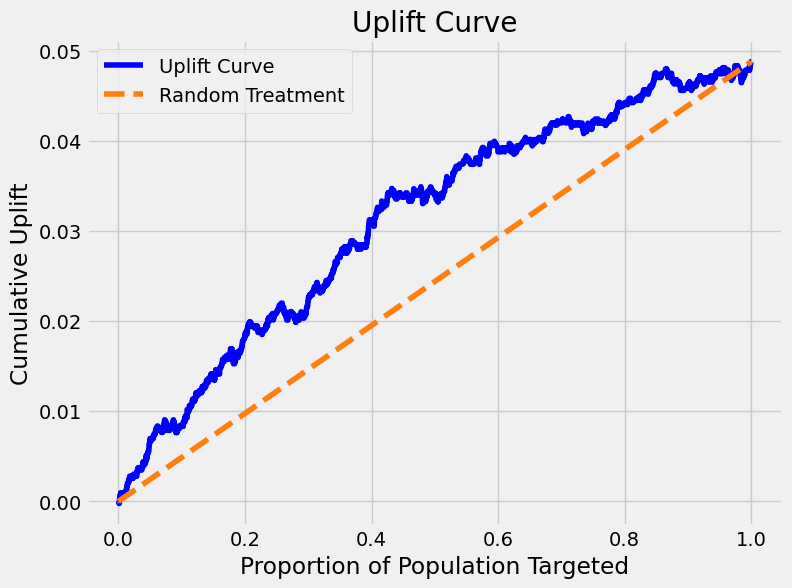

In [297]:
# Plot the uplift curve
plt.figure(figsize=(8, 6))
plt.plot(
    x_axis, 
    y_axis, 
    color='b', 
    label='Uplift Curve'
)
plt.plot(
    [0, max(x_axis)],
    [0, max(y_axis)],
    "--",
    color="tab:orange",
    label="Random Treatment",
)
plt.xlabel('Proportion of Population Targeted')
plt.ylabel('Cumulative Uplift')
plt.title('Uplift Curve')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

We will want to target around the first 20% or 45% of the population, as these have the largest distance from the random treatment curve resulting in highest yielding gain